# Выбор локации для скважины

### Описание проекта

Мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

### Описание данных

Признаки:

    id — уникальный идентификатор скважины;
    f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
    
Цель:
    
    product — объём запасов в скважине (тыс. баррелей).

### План проведения работы

    Загрузим и подготовим данные. Поясним порядок действий.
    Обучим и проверим модель для каждого региона:
    2.1. Разобьём данные на обучающую и валидационную выборки в соотношении 75:25.
    2.2. Обучим модель и сделаем предсказания на валидационной выборке.
    2.3. Сохраним предсказания и правильные ответы на валидационной выборке.
    2.4. Напечатаем на экране средний запас предсказанного сырья и RMSE модели.
    2.5. Проанализируем результаты.
    Подготовимся к расчёту прибыли:
    3.1. Все ключевые значения для расчётов сохраним в отдельных переменных.
    3.2. Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе.
    3.3. Напишем выводы по этапу подготовки расчёта прибыли.
    Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
    4.1. Выберем скважины с максимальными значениями предсказаний.
    4.2. Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.
    4.3. Рассчитаем прибыль для полученного объёма сырья.
    Посчитаем риски и прибыль для каждого региона:
    5.1. Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
    5.2. Найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
    5.3. Напишем выводы: предложим регион для разработки скважин и обоснуем выбор.

### Дополнительные условия

    Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
    При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
    Бюджет на разработку скважин в регионе — 10 млрд рублей.
    При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
    После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport

from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyClassifier

Объявим глобальные переменные.

In [2]:
# соотношения выборок
TRAIN_RATIO = .75
VALID_RATIO = .25

# случайное зерно
SEED = 314159

Загрузим данные и посмотрим основную информацию по ним.

In [3]:
if os.path.exists('geo_data_0.csv'):
    df_0 = pd.read_csv('geo_data_0.csv')
else:
    df_0 = pd.read_csv('/datasets/geo_data_0.csv')
    
if os.path.exists('geo_data_1.csv'):
    df_1 = pd.read_csv('geo_data_1.csv')
else:
    df_1 = pd.read_csv('/datasets/geo_data_1.csv')
    
if os.path.exists('geo_data_2.csv'):
    df_2 = pd.read_csv('geo_data_2.csv')
else:
    df_2 = pd.read_csv('/datasets/geo_data_2.csv')

df_0.info()
print()
df_1.info()
print()
df_2.info()
print()
display(df_0.head())
display(df_1.head())
display(df_2.head())
display(df_0.describe().transpose())
display(df_1.describe().transpose())
display(df_2.describe().transpose())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Nul

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


In [4]:
df_0.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Пропусков в данных нет. Проверим дубликаты.

In [5]:
print(df_0.duplicated().sum())
print(df_1.duplicated().sum())
print(df_2.duplicated().sum())

0
0
0


Дубликатов нет. 

Столбец `id` не значимый, можно удалитить.

In [6]:
df_0.drop(columns='id', inplace=True)
df_1.drop(columns='id', inplace=True)
df_2.drop(columns='id', inplace=True)

Проверим корреляции в данных.

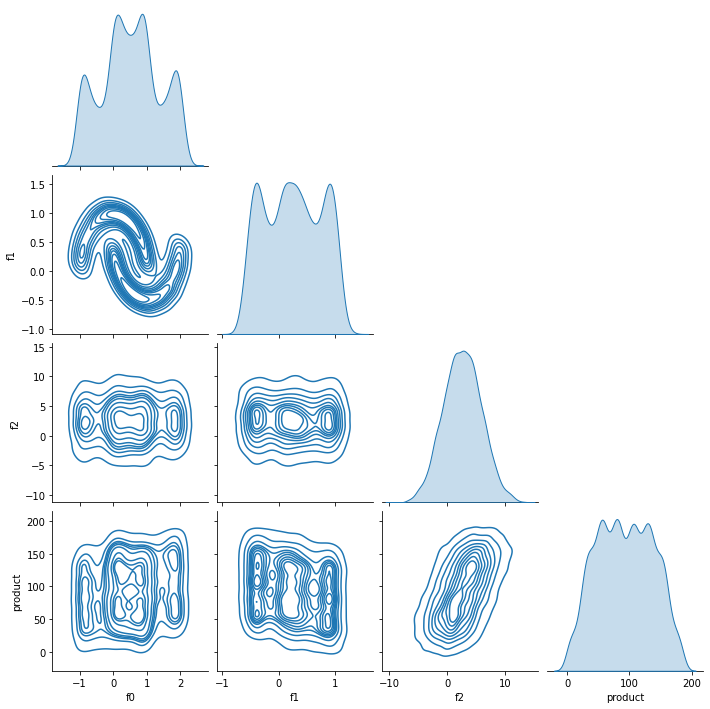

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [7]:
sns.pairplot(df_0.sample(frac=0.1, random_state=SEED), corner=True, kind='kde')
plt.show()

df_0.corr()

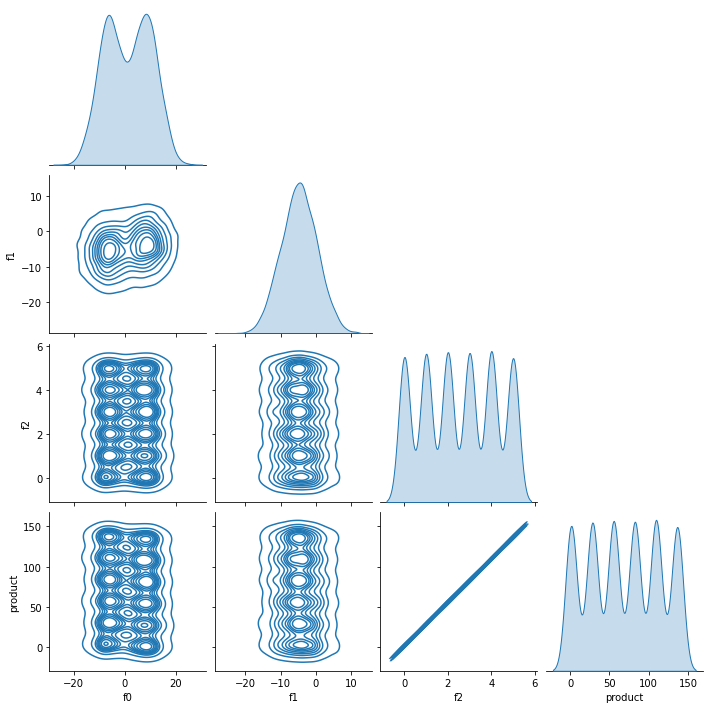

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [8]:
sns.pairplot(df_1.sample(frac=0.1, random_state=SEED), corner=True, kind='kde')
plt.show()

df_1.corr()

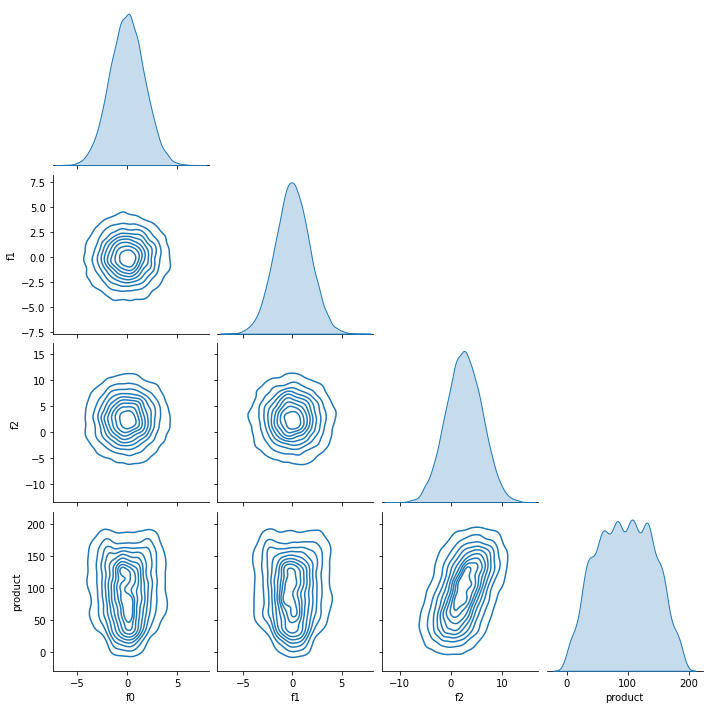

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


In [9]:
sns.pairplot(df_2.sample(frac=0.1, random_state=SEED), corner=True, kind='kde')
plt.show()

df_2.corr()

### Вывод

Мы загрузили данные и просмотрели основные сведения. Данные хорошо подготовлены, нет пропусков, дубликатов.

Удалили неинформативный столбец с названием скважины `id`.

По графикам отчётливо видна симметричность и, как причина, синтетичность данных. Нет явно выбивающихся значений.

Матрицы корреляции Пирсона показывают высокую зависимость показателя объёма запасов нефти от признака f2 для 0 и 2 региона. Для первого региона зависимость прямая и линейная.

## Обучение и проверка модели

Обучим и проверим модель для каждого региона.

   * разобьём данные на обучающую и валидационную выборки в соотношении 75:25
   * обучим модель и сделаем предсказания на валидационной выборке
   * сохраним предсказания и правильные ответы на валидационной выборке
   * напечатаем на экране средний запас предсказанного сырья и RMSE модели

In [10]:
# создадим списки имён регионов и их датасетов
df_names = ['0', '1', '2']
df_frames = [df_0, df_1, df_2]

# создадим словарь для хранения фактического и предсказанных значений набора valid
targets = {}

# пройдём циклом по парам имя-датасет
for name, frame in zip(df_names, df_frames):
    
    # создадим для каждой пары наборы признаков и целей
    target = frame['product']
    features = frame.drop('product', axis=1)
        
    # разделим признаки и цели на train и valid наборы
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target,
        test_size=VALID_RATIO,
        random_state=SEED,
    )
    
    # создадим pipeline их скелера и модели линейной регрессии
    model = make_pipeline(StandardScaler(), LinearRegression())
    
    # обучим модель на train'е
    model.fit(features_train, target_train)
    
    # запишем фактические данные и предсказанные в словарь
    targets[name] = (target_valid,
                     pd.Series(model.predict(features_valid),
                               index=target_valid.index,
                               name='product_predicted'))
    
    # напечатаем на экране средний запас предсказанного сырья и RMSE модели
    print()
    print(f'Для {name} региона:')
    print(f'Средний запас фактического сырья = {targets[name][0].mean():.2f} тыс. баррелей')
    print(f'Средний запас предсказанного сырья = {targets[name][1].mean():.2f} тыс. баррелей')
    print(f'Разница = {(1-targets[name][0].mean()/targets[name][1].mean()):.2%}')
    print(f'RMSE модели = {(mean_squared_error(target_valid, targets[name][1])**0.5):.2f} тыс. баррелей')


Для 0 региона:
Средний запас фактического сырья = 92.26 тыс. баррелей
Средний запас предсказанного сырья = 92.64 тыс. баррелей
Разница = 0.41%
RMSE модели = 37.64 тыс. баррелей

Для 1 региона:
Средний запас фактического сырья = 68.74 тыс. баррелей
Средний запас предсказанного сырья = 68.74 тыс. баррелей
Разница = 0.00%
RMSE модели = 0.89 тыс. баррелей

Для 2 региона:
Средний запас фактического сырья = 94.83 тыс. баррелей
Средний запас предсказанного сырья = 94.79 тыс. баррелей
Разница = -0.04%
RMSE модели = 40.18 тыс. баррелей


### Вывод

Мы разбили данные по каждому региону на тренировочную и валидационные выборки. Создали pipeline'ы масштабирования и обучения линейной регрессии.

Ожидаемо, лучше всего модель показала себя на 1 регионе где признак f2 показал прямую корреляцию с целевым значением. Разницы с фактическими значениями нет, RMSE составила всего 0,89 тыс. баррелей.

Разница с фактом хуже всего в 0 регионе - 0,41%. Наибольшая RMSE во 2 регионе - 40,18 тыс. баррелей.

## Подготовка к расчёту прибыли

Сохраним ключевые значения для расчётов в отдельных переменных.

In [11]:
points_to_est = 500
best_for_dev = 200
budget = 10e9
barrel_price = 450e3
threshold = 0.025

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе.

In [12]:
# определим точку безубыточности
non_loss = budget / (barrel_price * best_for_dev)

print(f'Достаточный объём сырья для безубыточной разработки = {non_loss:.2f} тыс. баррелей.')

for name, frame in zip(df_names, df_frames):
    print()
    print(f'Средний запас в {name} регионе = {frame["product"].mean():.2f} тыс. баррелей.')
    print(f'Процент скважин с объёмом больше чем порог = {len(frame.query("product > @non_loss"))/len(frame):.2%}')
    print(f'Количество скважин в объёмом больше чем порог = {len(frame.query("product > @non_loss"))}')

Достаточный объём сырья для безубыточной разработки = 111.11 тыс. баррелей.

Средний запас в 0 регионе = 92.50 тыс. баррелей.
Процент скважин с объёмом больше чем порог = 36.58%
Количество скважин в объёмом больше чем порог = 36583

Средний запас в 1 регионе = 68.83 тыс. баррелей.
Процент скважин с объёмом больше чем порог = 16.54%
Количество скважин в объёмом больше чем порог = 16537

Средний запас в 2 регионе = 95.00 тыс. баррелей.
Процент скважин с объёмом больше чем порог = 38.18%
Количество скважин в объёмом больше чем порог = 38178


### Вывод

При текущих макропараметрах точка безубыточности составляет в среднем 111.11 тыс. баррелей на скважину, при этом средний запас в регионах лежит в промежутке 68-95 тыс. баррелей.

200 из 500 скважин это 40%. Процент скважин во всех регионах с запасами больше порога не доходит до 40%.

Таким образом можно сделать вывод о том что для того чтобы вложения в разработку окупились, отобранные моделью скважины должны позволять добывать ощутимо больше порогового значения.

## Расчёт прибыли

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.

   * выберем скважины с максимальными значениями предсказаний
   * просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.
   * рассчитаем прибыль для полученного объёма сырья

In [13]:
def revenue(target, probabilities, count):
    '''
    Функция принимает целевые фактические и предсказанные значения добычи нефти из скважины в тыс. баррелей,
    а также количество скважин для суммирования. Для валидационного набора данных.
    Возвращает прибыль в рублях с поданных скважин по фактическим данным.
    '''
    probs_sorted = probabilities.sort_values(ascending=False)[:count]
    selected = target[probs_sorted.index]
    return selected.sum() * barrel_price

### Вывод

Написали функцию для расчёта прибыли, можно переходить к подсчёту прибыли и рисков с помощью техники bootstrap.

## Посчитаем риски и прибыль для каждого региона:

   * Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
   * Найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

In [14]:
for name in df_names:
    
    state = np.random.RandomState(SEED)
    
    values = []
    
    for _ in range(1000):
        target_subsample = targets[name][0].sample(points_to_est, replace=True, random_state=state)
        probs_subsample = targets[name][1][target_subsample.index]
        values.append(revenue(target_subsample, probs_subsample, best_for_dev) - budget)
        
    values = pd.Series(values)
        
    mean = values.mean() / 10e6
    lower = values.quantile(.025) / 10e6
    upper = values.quantile(.975) / 10e6
    
    risk = values.apply(lambda x: x < 0).sum() / len(values)

    print()
    print(f'Для {name} региона:')
    print(f'Средняя валовая прибыль с 200 лучших скважин, отобраных по предсказанию = {mean:.0f} млн. рублей.')
    print(f'Доверительный интервал лежит между {lower:.0f} - {upper:.0f} млн. рублей.')
    print(f'Риск убытков составляет = {risk:.2%}')


Для 0 региона:
Средняя валовая прибыль с 200 лучших скважин, отобраных по предсказанию = 63 млн. рублей.
Доверительный интервал лежит между 2 - 130 млн. рублей.
Риск убытков составляет = 2.10%

Для 1 региона:
Средняя валовая прибыль с 200 лучших скважин, отобраных по предсказанию = 65 млн. рублей.
Доверительный интервал лежит между 15 - 122 млн. рублей.
Риск убытков составляет = 0.20%

Для 2 региона:
Средняя валовая прибыль с 200 лучших скважин, отобраных по предсказанию = 53 млн. рублей.
Доверительный интервал лежит между -10 - 120 млн. рублей.
Риск убытков составляет = 5.10%


### Вывод

Наибольшая потенциальная прибыль по поценке модели будет в первом регионе - 65 млн. рублей.

Наименьший риск убытков составляет 0.2%, также в первом регионе.

Наибольшая потенциальная прибыль составляет 130 млн. рублей для нулевого региона.

По совокупности факторов можно рекомендовать для разработки первый регион, как имеющий наибольшую среднюю потенциальную прибыль и минимальные риски.

## Общий вывод

В ходе работы нами были обработаны данные по трём регионам для добычи нефти.

Мы обработали данные:
   * исследовали предоставленные данные
   * проверили пропуски
   * проверили дубликаты
   * посмотрели корреляции в данных
   
Мы составили пайплайн и обучили модель на полученных данных.

Сделали необходимые преготовления и с помощью метода bootstrap проанализировали качество модели на фактических данных.

Мы увидели что наименьший риск и наибольшая средняя потенциальная прибыль получилась в первом регионе, его мы и порекомендуем заказчику для разработки.